In [17]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

In [5]:
test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

In [6]:
device = 'mps'
tn = 8.
tf = 12.

In [7]:
model = torch.load('model_nerfs').to(device)

/var/folders/wv/_x9hjmys03x5gnbfl70ry2sr0000gn/T/ipykernel_4074/2219720236.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_nerfs').to(device)


In [8]:
def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))


@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):
    
    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)
    
    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()
    
    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)
    
    if target is not None: 
        return image, mse, psnr
    else:
        return image

In [19]:
from rendering import rendering
img, mse, psnr = test(
    model,
    torch.from_numpy(test_o[1]).to(device).to(torch.float32),
    torch.from_numpy(test_d[1]).to(device).to(torch.float32),
    tn, tf,
    nb_bins=100,
    chunk_size=10,
    target=test_target_px_values[1].reshape(400, 400, 3)
)
print(psnr)

11.535920581383309


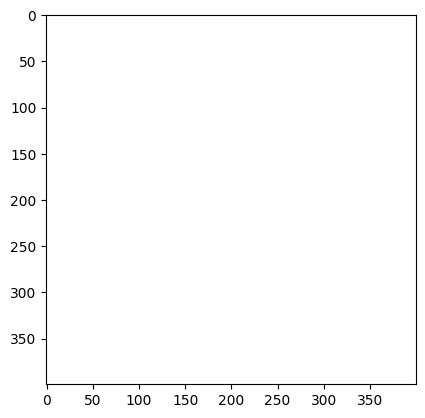

In [20]:
plt.imshow(img)